In [1]:
# Importing necessary paackages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
seed = 4353

In [2]:
loc1 = r'C:\Users\madhu\Downloads\Compressed\fake-and-real-news-dataset\True.csv'
loc2 = r'C:\Users\madhu\Downloads\Compressed\fake-and-real-news-dataset\Fake.csv'

In [3]:
true = pd.read_csv(loc1)
fake = pd.read_csv(loc2)

In [4]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
fake.sample(5)

,title,text,subject,date
15987,AUDIT: Obama’s IRS ‘Misled’ Americans to Get T...,Soooo the IRS lied to Americans to prod them...,Government News,"Aug 4, 2017"
16452,HACKED! COMMIE GEORGE SOROS Hacked By DC Leaks!,Thank you DC Leaks! It s about time George Sor...,Government News,"Aug 13, 2016"
13218,WATCH HILLARY SUPPORTERS Weigh In On The Secon...,It sounds pretty good to me Maybe they think ...,politics,"Aug 18, 2016"
8990,WATCH The Hilarious ‘Goodbye’ Video Posted By...,"Thus far, the Oregon militia members who have ...",News,"January 3, 2016"
21773,HOW A SINGLE FEDERAL BUREAUCRAT OPENED THE DOO...,Meet Alice Miller who single-handedly scr*wed ...,left-news,"May 6, 2015"


In [6]:
true['impression']=1
fake['impression']=0

In [7]:
data_raw = pd.concat([true, fake], axis=0)
data_raw.sample(10)

,title,text,subject,date,impression
10749,MELANIA TRUMP Proves ‘Dressing Well Is The Bes...,If you weren t convinced of the fabulousness o...,politics,"May 30, 2017",0
18064,BREAKING NEWS: SEBASTIAN GORKA OUT…Are Ivanka ...,"UPDATE: White House official says, ""Sebastian ...",left-news,"Aug 25, 2017",0
1965,Hillary Clinton Just Took Sean Spicer And Bil...,While delivering the closing remarks at Tuesda...,News,"March 29, 2017",0
7921,Ford chairman met with Trump over 'infuriating...,WASHINGTON (Reuters) - Ford Motor Co (F.N) Exe...,politicsNews,"October 5, 2016",1
16637,Russian presidential hopeful says she won't sl...,"MOSCOW (Reuters) - Ksenia Sobchak, a Russian T...",worldnews,"October 24, 2017",1
19310,MEDIA ATTACKS TAYLOR SWIFT Over Refusal To Cri...,Tom Barnes mocks Taylor Swift in his latest ar...,left-news,"Jan 14, 2017",0
10900,MICHELLE OBAMA COMES OUT OF HIDING To Accuse P...,Michelle came out of hiding today to take a ba...,politics,"May 12, 2017",0
10938,"Trump calls for waterboarding, other methods i...",WASHINGTON (Reuters) - U.S. Republican White H...,politicsNews,"February 7, 2016",1
6229,Republican defends border-adjustment tax after...,WASHINGTON (Reuters) - A top Republican in Con...,politicsNews,"January 18, 2017",1
8555,SNL Parodies All-White Oscars In Brutal Smack...,"Last night, Saturday Night Live delivered a br...",News,"January 24, 2016",0


In [8]:
data_raw['fulltext'] = data_raw.title + ' ' + data_raw.text
data_raw.drop(['title','text'], axis=1, inplace=True)

In [9]:
data = data_raw[['fulltext', 'impression']]
data = data.reset_index()
data.drop(['index'], axis=1, inplace=True)

In [10]:
data.isnull().sum()

fulltext      0
impression    0
dtype: int64

In [11]:
print('The dataset contans {} rows and {} columns'.format(data.shape[0], data.shape[1]))

The dataset contans 44898 rows and 2 columns


In [12]:
X_data = data['fulltext']
y_data = data.impression

In [13]:
X_data = X_data.astype(str)

In [14]:
X_data

0        As U.S. budget fight looms, Republicans flip t...
1        U.S. military to accept transgender recruits o...
2        Senior U.S. Republican senator: 'Let Mr. Muell...
3        FBI Russia probe helped by Australian diplomat...
4        Trump wants Postal Service to charge 'much mor...
                               ...                        
44893    McPain: John McCain Furious That Iran Treated ...
44894    JUSTICE? Yahoo Settles E-mail Privacy Class-ac...
44895    Sunnistan: US and Allied ‘Safe Zone’ Plan to T...
44896    How to Blow $700 Million: Al Jazeera America F...
44897    10 U.S. Navy Sailors Held by Iranian Military ...
Name: fulltext, Length: 44898, dtype: object

In [15]:
X_data[1]

'U.S. military to accept transgender recruits on Monday: Pentagon WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in Washington and one in Virginia, last week rejected the administration’s request to put on hold orders by lower court judges requiring the military to begin accepting transgender recruits on Jan. 1. A Justice Department official said the administration will not challenge those rulings. “The Department of Defense has announced that it will be releasing an independent study of these issues in the coming weeks. So rather than litigate this interim appeal before that occurs, the administration has decided to wait for DOD’s study and will continue to defend the president’s lawful authority in District 

In [16]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [17]:
def final(X_data_full):
    
    # function for removing punctuations
    def remove_punct(X_data_func):
        string1 = X_data_func.lower()
        translation_table = dict.fromkeys(map(ord, string.punctuation),' ')
        string2 = string1.translate(translation_table)
        return string2
    
    X_data_full_clear_punct = []
    for i in range(len(X_data_full)):
        test_data = remove_punct(X_data_full[i])
        X_data_full_clear_punct.append(test_data)
        
    # function to remove stopwords
    def remove_stopwords(X_data_func):
        pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
        string2 = pattern.sub(' ', X_data_func)
        return string2
    
    X_data_full_clear_stopwords = []
    for i in range(len(X_data_full)):
        test_data = remove_stopwords(X_data_full[i])
        X_data_full_clear_stopwords.append(test_data)
        
    # function for tokenizing
    def tokenize_words(X_data_func):
        words = nltk.word_tokenize(X_data_func)
        return words
    
    X_data_full_tokenized_words = []
    for i in range(len(X_data_full)):
        test_data = tokenize_words(X_data_full[i])
        X_data_full_tokenized_words.append(test_data)
        
    # function for lemmatizing
    lemmatizer = WordNetLemmatizer()
    def lemmatize_words(X_data_func):
        words = lemmatizer.lemmatize(X_data_func)
        return words
    
    X_data_full_lemmatized_words = []
    for i in range(len(X_data_full)):
        test_data = lemmatize_words(X_data_full[i])
        X_data_full_lemmatized_words.append(test_data)
        
    # creating the bag of words model
    cv = CountVectorizer(max_features=1000)
    X_data_full_vector = cv.fit_transform(X_data_full_lemmatized_words).toarray()
    
    
    tfidf = TfidfTransformer()
    X_data_full_tfidf = tfidf.fit_transform(X_data_full_vector).toarray()
    
    return X_data_full_tfidf

In [18]:
data_X = final(X_data)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(data_X, y_data, test_size=0.25, random_state= seed)

#### Naive Bayes

In [20]:
MNB = MultinomialNB()
MNB.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [21]:
predictions = MNB.predict(X_test)

In [22]:
# Model evaluation

print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

MNB_f1 = round(f1_score(y_test, predictions, average='weighted'), 3)
MNB_accuracy = round((accuracy_score(y_test, predictions)*100),2)

print("Accuracy : " , MNB_accuracy , " %")
print("f1_score : " , MNB_f1)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      5849
           1       0.93      0.92      0.93      5376

    accuracy                           0.93     11225
   macro avg       0.93      0.93      0.93     11225
weighted avg       0.93      0.93      0.93     11225

[[5468  381]
 [ 407 4969]]
Accuracy :  92.98  %
f1_score :  0.93


#### Random forest

In [24]:
# Instatiation, fitting and prediction
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_estimators= 10, random_state= seed)
rfc.fit(X_train, y_train)
predictions = rfc.predict(X_test)

In [25]:
# Model evaluation

print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

rfc_f1 = round(f1_score(y_test, predictions, average= 'weighted'), 3)
rfc_accuracy = round((accuracy_score(y_test, predictions) * 100), 2)

print("Accuracy : " , rfc_accuracy , " %")
print("f1_score : " , rfc_f1)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5849
           1       1.00      0.99      0.99      5376

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225

[[5835   14]
 [  60 5316]]
Accuracy :  99.34  %
f1_score :  0.993


#### Text processing

In [26]:
true_text = data[data.impression==1]['fulltext']
fake_text = data[data.impression==0]['fulltext']
fake_text = fake_text.reset_index().drop(['index'], axis=1)

In [27]:
def wordcloud_words(X_data_full):
    
    # function for removing punctuations
    def remove_punct(X_data_func):
        string1 = X_data_func.lower()
        translation_table = dict.fromkeys(map(ord, string.punctuation),' ')
        string2 = string1.translate(translation_table)
        return string2
    
    X_data_full_clear_punct = []
    for i in range(len(X_data_full)):
        test_data = remove_punct(X_data_full[i])
        X_data_full_clear_punct.append(test_data)
        
    # function to remove stopwords
    def remove_stopwords(X_data_func):
        pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
        string2 = pattern.sub(' ', X_data_func)
        return string2
    
    X_data_full_clear_stopwords = []
    for i in range(len(X_data_full)):
        test_data = remove_stopwords(X_data_full[i])
        X_data_full_clear_stopwords.append(test_data)
        
    # function for tokenizing
    def tokenize_words(X_data_func):
        words = nltk.word_tokenize(X_data_func)
        return words
    
    X_data_full_tokenized_words = []
    for i in range(len(X_data_full)):
        test_data = tokenize_words(X_data_full[i])
        X_data_full_tokenized_words.append(test_data)
        
    # function for lemmatizing
    lemmatizer = WordNetLemmatizer()
    def lemmatize_words(X_data_func):
        words = lemmatizer.lemmatize(X_data_func)
        return words
    
    X_data_full_lemmatized_words = []
    for i in range(len(X_data_full)):
        test_data = lemmatize_words(X_data_full[i])
        X_data_full_lemmatized_words.append(test_data)
        
    return X_data_full_lemmatized_words

In [28]:
true_words = wordcloud_words(true_text)

In [29]:
def plot_wordcloud(text):
    wordcloud = WordCloud(background_color = 'black',
                         max_words = 3000,
                         width=1600,
                         height=800).generate(text)
    plt.clf()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

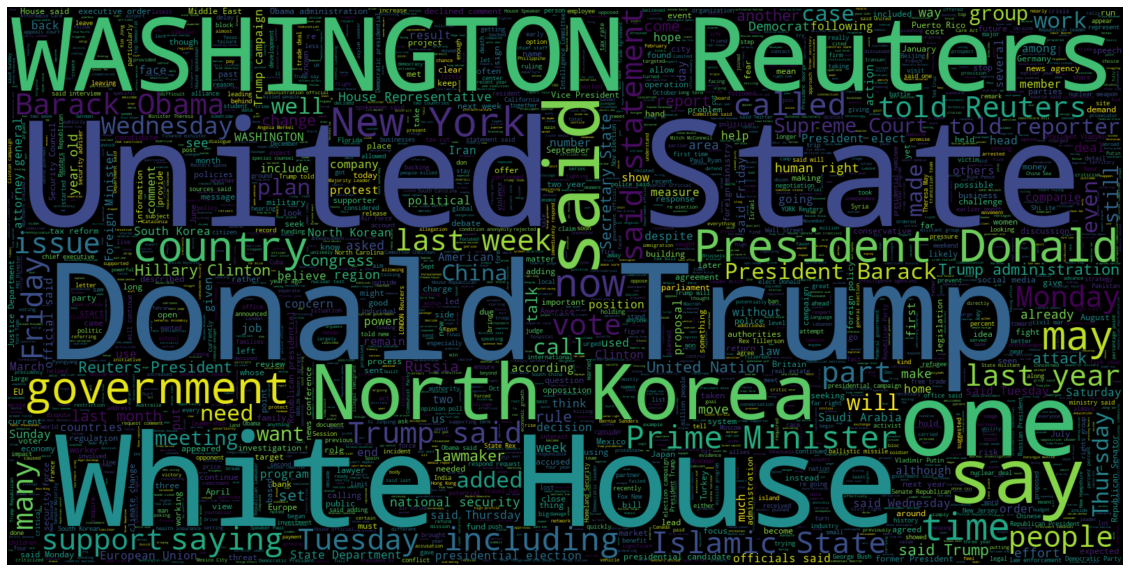

In [30]:
plt.figure(figsize=(20,20))
plot_wordcloud(' '.join(true_words))

In [31]:
fake_words = wordcloud_words(fake_text.fulltext)

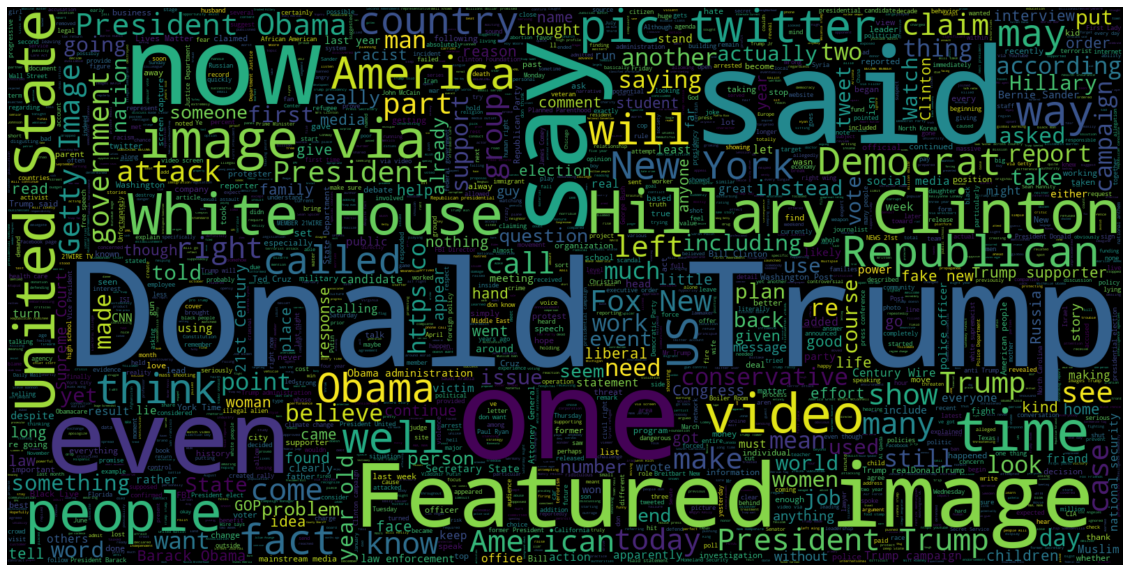

In [32]:
plt.figure(figsize=(20,20))
plot_wordcloud(' '.join(fake_words))